In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

import gymnasium as gym
import gym_trading_env

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from RLTrade.agent import DQNAgent
from RLTrade.utils import (
    stationaryDGP, 
    nonstationaryDGP, 
    build_features, 
    build_rolling_feature,
)

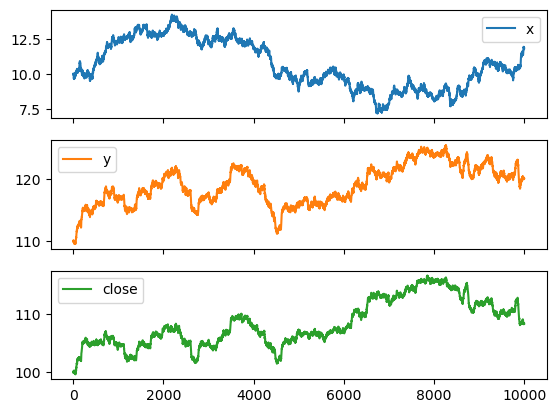

In [2]:
x, y = nonstationaryDGP()
spread = y - x
df = pd.DataFrame({'x': x, 'y': y, 'close': spread}) # close price of portfolio is the spread
df.plot(subplots=True)
plt.show()

In [3]:
# confirm the x, y pair is not cointegrated
x_ols = sm.add_constant(x)
ols = sm.OLS(y, x_ols).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     749.2
Date:                Tue, 04 Jun 2024   Prob (F-statistic):          3.97e-159
Time:                        18:39:58   Log-Likelihood:                -25381.
No. Observations:               10000   AIC:                         5.077e+04
Df Residuals:                    9998   BIC:                         5.078e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        124.2111      0.193    643.534      0.0

In [4]:
adfuller_test = adfuller(spread)
print(f'ADF Statistic: {adfuller_test[0]}')
print(f'p-value: {adfuller_test[1]}')
print('Is the spread stationary? {}'.format('Yes' if adfuller_test[1] < 0.05 else 'No'))

ADF Statistic: -2.2070917003182213
p-value: 0.20368165467060018
Is the spread stationary? No


In [5]:
# build features
df_train = df.copy()

feature_config = {
    "feature_col": "close",
    "window": 7, # 7 days window, pad with first value when window is not available
    "mode": "default", # difference between current and previous close price
    "mean_correction": True,
}

df_train = build_rolling_feature(df_train, **feature_config)
df_train

,x,y,close,feature_rolling_0,feature_rolling_1,feature_rolling_2,feature_rolling_3,feature_rolling_4,feature_rolling_5,feature_rolling_6
0,10.000063,109.986133,99.986070,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,10.021078,109.851457,99.830380,-0.133449,0.022241,0.022241,0.022241,0.022241,0.022241,0.022241
2,9.985405,109.876063,99.890659,-0.059540,-0.119819,0.035872,0.035872,0.035872,0.035872,0.035872
3,9.943222,109.819120,99.875898,-0.058562,-0.043801,-0.104080,0.051611,0.051611,0.051611,0.051611
4,9.919902,109.867230,99.947327,0.018403,-0.053027,-0.038266,-0.098545,0.057145,0.057145,0.057145
...,...,...,...,...,...,...,...,...,...,...
9995,11.765177,120.170824,108.405648,0.091120,0.040018,-0.050291,-0.081727,-0.025313,0.033397,-0.007203
9996,11.757820,120.099126,108.341306,0.021924,0.086265,0.035164,-0.055145,-0.086582,-0.030168,0.028542
9997,11.768964,120.223840,108.454877,0.120215,0.006645,0.070986,0.019885,-0.070424,-0.101861,-0.045447
9998,11.781086,120.187359,108.406272,0.054889,0.103493,-0.010077,0.054264,0.003162,-0.087147,-0.118583


In [6]:
# Define the environment
env_action_space = [-1, 0, 1] # Positions : [-1=SHORT, 0=OUT, 1=LONG]
# env_action_space = [i/10 for i in range(-10, 11)] # Positions : [-1, -0.9, -0.8, ..., 0, 0.1, 0.2, ..., 1]

env = gym.make("TradingEnv",
        name= "stationaryDGP",
        df = df_train, # Your dataset with your custom features
        positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
        trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
        borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        # max_episode_duration=180
    )
env.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
env.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

# Run an episode until it ends :
done, truncated = False, False
observation, info = env.reset()
print(observation)
while not done and not truncated:
    # Pick a position by its index in your position list (=[-1, 0, 1])....usually something like : position_index = your_policy(observation)
    position_index = env.action_space.sample() # At every timestep, pick a random position index from your position list (=[-1, 0, 1])
    observation, reward, done, truncated, info = env.step(0) # always short position

[0. 0. 0. 0. 0. 0. 0. 1. 1.]
Market Return :  8.36%   |   Portfolio Return : -8.38%   |   Position Changes : 1   |   Episode Length : 10000   |   


In [7]:
# Train a DQN agent using training data from a stationary data generating process
n_actions = env.action_space.n
n_observations = len(env.reset()[0])

agent = DQNAgent(n_observations=n_observations, n_actions=n_actions)
history_metrics, _ = agent.train(env, num_episodes=15) # Beware of overfitting when num_episodes is too high

Market Return :  8.36%   |   Portfolio Return : -49.22%   |   Position Changes : 5721   |   Episode Length : 10000   |   
Market Return :  8.36%   |   Portfolio Return : -30.73%   |   Position Changes : 4801   |   Episode Length : 10000   |   
Market Return :  8.36%   |   Portfolio Return : -30.18%   |   Position Changes : 4718   |   Episode Length : 10000   |   
Market Return :  8.36%   |   Portfolio Return : -32.72%   |   Position Changes : 4656   |   Episode Length : 10000   |   
Market Return :  8.36%   |   Portfolio Return : -18.37%   |   Position Changes : 4626   |   Episode Length : 10000   |   
Market Return :  8.36%   |   Portfolio Return : -25.69%   |   Position Changes : 4532   |   Episode Length : 10000   |   
Market Return :  8.36%   |   Portfolio Return : -17.34%   |   Position Changes : 4502   |   Episode Length : 10000   |   
Market Return :  8.36%   |   Portfolio Return : -14.49%   |   Position Changes : 4472   |   Episode Length : 10000   |   
Market Return :  8.36%  

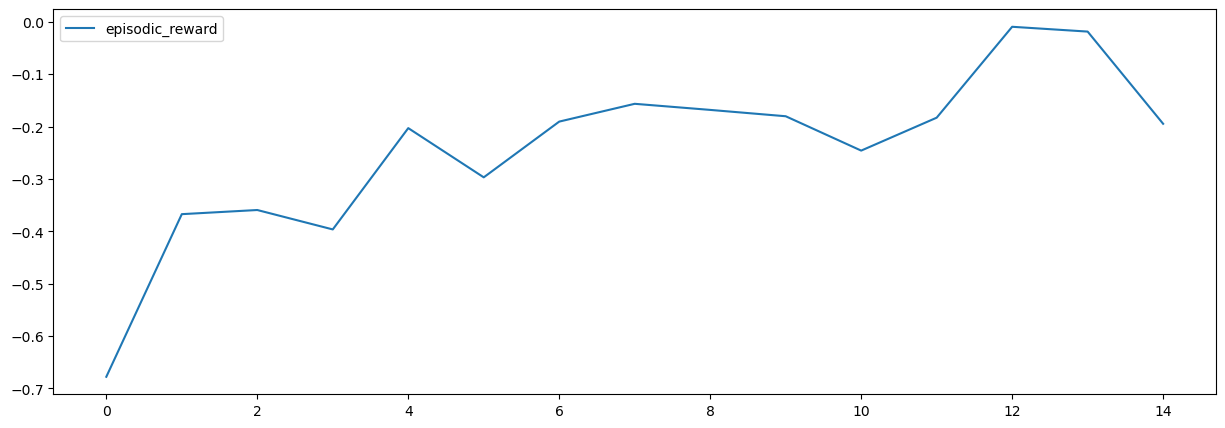

In [8]:
all_metrics = pd.DataFrame(history_metrics)
perc2float = lambda x: float(x.strip('%'))/100

all_metrics["Market Return"] = all_metrics["Market Return"].apply(perc2float)
all_metrics["Portfolio Return"] = all_metrics["Portfolio Return"].apply(perc2float)

all_metrics.plot(y=["episodic_reward"], figsize=(15, 5))
plt.show()

In [10]:
# Evaluate the agent on a new dataset from the same data generating process
returns = []
for i in range(10):
    x, y = nonstationaryDGP()
    spread = y - x
    _df = pd.DataFrame({'x': x, 'y': y, 'close': spread})
    _df = build_rolling_feature(_df, **feature_config)
    
    env_test = gym.make("TradingEnv",
            name= "stationaryDGP",
            df = _df, # Your dataset with your custom features
            positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
            trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
            borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        )
    env_test.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
    env_test.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

    env_test = agent.eval(env_test)
    returns.append(perc2float(env_test.unwrapped.get_metrics()["Portfolio Return"]))

print(f"Average Portfolio Return: {np.mean(returns)}")
print(f"Std Portfolio Return: {np.std(returns)}")

Market Return : -87.45%   |   Portfolio Return : -39.19%   |   Position Changes : 5759   |   Episode Length : 10000   |   
Market Return : -17.94%   |   Portfolio Return : -57.46%   |   Position Changes : 6557   |   Episode Length : 10000   |   
Market Return : -11.21%   |   Portfolio Return : -56.99%   |   Position Changes : 6511   |   Episode Length : 10000   |   
Market Return : -6.59%   |   Portfolio Return : -60.74%   |   Position Changes : 6410   |   Episode Length : 10000   |   
Market Return : -4.87%   |   Portfolio Return : -63.79%   |   Position Changes : 6470   |   Episode Length : 10000   |   
Market Return : -4.42%   |   Portfolio Return : -56.95%   |   Position Changes : 6516   |   Episode Length : 10000   |   
Market Return : -10.09%   |   Portfolio Return : -62.62%   |   Position Changes : 6452   |   Episode Length : 10000   |   
Market Return :  8.54%   |   Portfolio Return : -62.03%   |   Position Changes : 6559   |   Episode Length : 10000   |   
Market Return : -6.2